In [1]:
import math
import sys
from functools import partial
import matplotlib.pyplot as plt
import torch
sys.path.append("..")
import src.models.ebm.normal_params
from src.models.ebm.normal_params import NormalEbm
from src.noise_distr.normal import Normal
%load_ext autoreload
%autoreload 2

In [2]:
def energy(y, mu, sigma_sq):
    dist_sq = (y-mu)**2
    return dist_sq / (2 * sigma_sq)

def score(energy, pos_map):
    return pos_map(- energy)

def true_part_fn(sigma_sq):
    return (torch.sqrt(2 * math.pi * sigma_sq))

def gauss_pdf(y, mu, sigma_sq, pos_map, part_fn):
    en = energy(y, mu, sigma_sq)
    sc = score(en, pos_map)
    return sc / part_fn

def true_pdf(y, mu, sigma_sq):
    return gauss_pdf(y, mu, sigma_sq, torch.exp, true_part_fn(sigma_sq))

def nce_pdf(y, mu, sigma_sq, pos_map, noise_distr, energy):
    part_fn = nce_part_fn(y, y_samples, mu, sigma_sq, energy, noise_distr, pos_map)
    return gauss_pdf(y, mu, sigma_sq, pos_map, part_fn)

pos_map = torch.exp

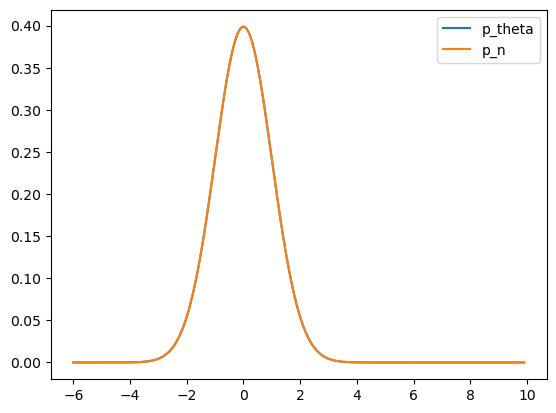

In [3]:
noise_mu = torch.tensor(0)
noise_sigma_sq = torch.tensor(1)
p_n = Normal(noise_mu, noise_sigma_sq)
#en_mu = torch.randn(1, requires_grad=True)
#en_var_logit = torch.randn(1, requires_grad=True)
#en_sigma_sq = torch.exp(en_var_logit)

en_mu = torch.tensor(0)
en_sigma_sq = torch.tensor(1)
ebm = NormalEbm(en_mu, en_sigma_sq)


y = torch.tensor(0)

fig, ax = plt.subplots()
y_min = -6
y_max = 10
# noise_mu-5*torch.sqrt(noise_sigma_sq)
y_range = torch.arange(y_min,
                       y_max,
                       step=0.1)

ax.plot(y_range, ebm.prob(y_range), label="p_theta")
ax.plot(y_range, p_n.prob(y_range), label="p_n")

ax.legend()


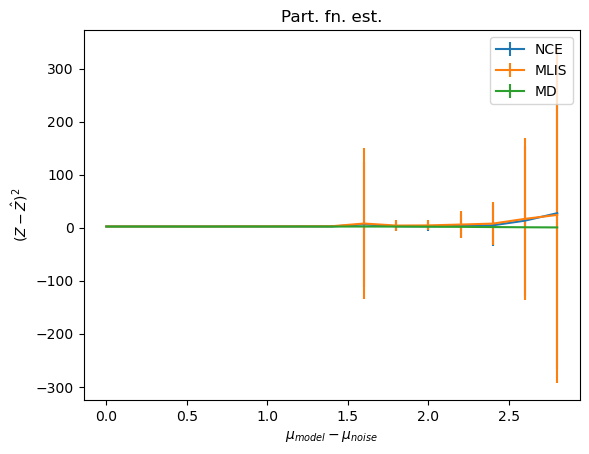

In [18]:
from src.nce.rank import NceRankCrit
from src.mlis.mlis import MlisCrit
from src.md.md import MdCrit
from src.models.ebm.normal_params import normal_part_fn

en_mu = torch.tensor(0)
en_sigma_sq = torch.tensor(1)
ebm = NormalEbm(en_mu, en_sigma_sq)

num_neg_samples = 10

mu_min, mu_max = 0, 3
num_mc = 1000
noise_mus = torch.arange(mu_min, mu_max, step=0.2)

nce_zs = torch.empty((noise_mus.size(0), num_mc))
mlis_zs = torch.empty(nce_zs.size())
md_zs = torch.empty(nce_zs.size())
         
y = y.reshape(1, 1)
for mu_it, noise_mu in enumerate(noise_mus):
    for mc_it in range(num_mc):
        y_samples = (torch.sqrt(noise_sigma_sq) * torch.randn(num_neg_samples, requires_grad=False) + noise_mu).reshape(-1, 1)
        

        p_n = Normal(noise_mu, noise_sigma_sq)
        
        nce = NceRankCrit(ebm, p_n)
        mlis = MlisCrit(ebm, p_n)
        md = MdCrit(ebm, p_n, normal_part_fn(en_sigma_sq))

        nce_zs[mu_it, mc_it] = nce.part_fn(y, y_samples)
        mlis_zs[mu_it, mc_it] = mlis.part_fn(y, y_samples)
        md_zs[mu_it, mc_it] = md.part_fn(y, y_samples)

true_z = true_part_fn(en_sigma_sq)
nce_devs = (nce_zs - true_z)**2
nce_mean, nce_std = nce_devs.mean(axis=1), nce_devs.std(axis=1)
mlis_devs = (mlis_zs - true_z)**2
mlis_mean, mlis_std = mlis_devs.mean(axis=1), mlis_devs.std(axis=1)
md_devs = (md_zs - true_z)**2
md_mean, md_std = md_devs.mean(axis=1), md_devs.std(axis=1)

fig, ax = plt.subplots()
ax.set_title("Part. fn. est.")
ax.set_xlabel("$\mu_{model} - \mu_{noise}$")
ax.set_ylabel("$(Z - \hat{Z})^2$")

#ax.plot(noise_mus, nce_mean, label="NCE")
#ax.plot(noise_mus, nce_mean, label="NCE")
plt.errorbar(noise_mus, nce_mean, yerr=nce_std, label="NCE")
plt.errorbar(noise_mus, mlis_mean, yerr=mlis_std, label="MLIS")
plt.errorbar(noise_mus, md_mean, yerr=md_std, label="MD")

ax.legend()

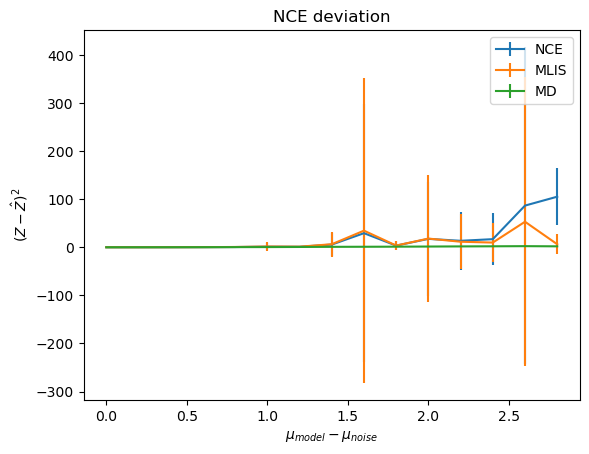

In [19]:
# Older manual version
def nce_part_fn(y, y_samples, mu, sigma_sq, energy, noise_distr, pos_map):
    y = y.reshape((1,))
    ys = torch.cat((y, y_samples))
    w_tilde = pos_map( -energy(ys, mu, sigma_sq)) / noise_distr(ys)
    return w_tilde.sum() / (y_samples.size(0) + 1)

def mlis_part_fn(y_samples, mu, sigma_sq, energy, noise_distr, pos_map):
    return (pos_map( -energy(y_samples, mu, sigma_sq)) / noise_distr(y_samples)).sum() / y_samples.size(0)

def md_part_fn(y, y_samples, mu, sigma_sq, energy, noise_distr, pos_map):
    num_neg = y_samples.size(0)
    true_z = true_part_fn(sigma_sq)
    y = torch.tensor(1.0).reshape((1,))
    ys = torch.cat((y, y_samples))
    
    model_part = 1 / (num_neg + 1) * pos_map(- energy(ys, mu, sigma_sq)) / true_z
    noise_part = num_neg / (num_neg+1) * noise_distr(ys)
    p_md = model_part + noise_part
    return (pos_map( -energy(ys, mu, sigma_sq)) / p_md).sum() / (y_samples.size(0) + 1)

num_neg_samples = 10

mu_min, mu_max = 0, 3
num_mc = 100
noise_mus = torch.arange(mu_min, mu_max, step=0.2)

nce_zs = torch.empty((noise_mus.size(0), num_mc))
mlis_zs = torch.empty(nce_zs.size())
md_zs = torch.empty(nce_zs.size())
                                             
for mu_it, noise_mu in enumerate(noise_mus):
    for mc_it in range(num_mc):
        y_samples = torch.sqrt(noise_sigma_sq) * torch.randn(num_neg_samples, requires_grad=False) + noise_mu
        noise_distr = partial(true_pdf, mu=noise_mu, sigma_sq=noise_sigma_sq)
        nce_zs[mu_it, mc_it] = nce_part_fn(y, y_samples, en_mu, en_sigma_sq, energy, noise_distr, pos_map)
        mlis_zs[mu_it, mc_it] = mlis_part_fn(y_samples, en_mu, en_sigma_sq, energy, noise_distr, pos_map)
        md_zs[mu_it, mc_it] = md_part_fn(y, y_samples, en_mu, en_sigma_sq, energy, noise_distr, pos_map)

        


true_z = true_part_fn(en_sigma_sq)
nce_devs = (nce_zs - true_z)**2
nce_mean, nce_std = nce_devs.mean(axis=1), nce_devs.std(axis=1)
mlis_devs = (mlis_zs - true_z)**2
mlis_mean, mlis_std = mlis_devs.mean(axis=1), mlis_devs.std(axis=1)
md_devs = (md_zs - true_z)**2
md_mean, md_std = md_devs.mean(axis=1), md_devs.std(axis=1)

fig, ax = plt.subplots()
ax.set_title("NCE deviation")
ax.set_xlabel("$\mu_{model} - \mu_{noise}$")
ax.set_ylabel("$(Z - \hat{Z})^2$")

#ax.plot(noise_mus, nce_mean, label="NCE")
#ax.plot(noise_mus, nce_mean, label="NCE")
plt.errorbar(noise_mus, nce_mean, yerr=nce_std, label="NCE")
plt.errorbar(noise_mus, mlis_mean, yerr=mlis_std, label="MLIS")
plt.errorbar(noise_mus, md_mean, yerr=md_std, label="MD")

ax.legend()
